## Physics 512 Final Project - Fourier Optics
### Tucker Knaak - May 4th, 2022
### Code adapted from Dr. Jonathan Wrubel
##### Fourier optics allow us to turn a complex two-dimensional pattern into a two-dimensional transform at resolution and speed.  The diffraction pattern of an object formed by a lens can be modeled with a two-dimensional Fourier transform, and spatial filters or other lens can be used to produce a final reconstruction of the image.  In this code, we will construct different apertures and recreate the diffraction pattern and original apertures using Fourier Transforms.

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import csv
from numpy import sin, cos, tan, exp, log, pi, sqrt, abs
from numpy.fft import fft2, ifft2


In [2]:
#Boundaries and Initial Conditions
wavelength = 0.6328  #wavelength of HeNe red laser used [um]
nPoints = 2**12      #Four Fourier Transform requires power of two points
length = 10000       #total extent of image [um]


#1D arrays of x and y values
xvals = np.linspace(-0.5*length, 0.5*length, nPoints, False)
yvals = np.linspace(-0.5*length, 0.5*length, nPoints, False)


In [3]:
#Calculating Spatial Frequncies and Momenta of Fast Fourier Transform

#Setting frequency-domain variables: p = hbar*k [momentum]
shortestSpatialPeriod = 2*length / nPoints
highestSpatialFrequency = 2*pi / shortestSpatialPeriod
k = 2*pi / wavelength


#1D array calculating the transverse spatial frequencies
xfreq = np.linspace(-highestSpatialFrequency, highestSpatialFrequency, nPoints, False)
xfreq = np.fft.ifftshift(xfreq)
yfreq = np.linspace(-highestSpatialFrequency, highestSpatialFrequency, nPoints, False)
yfreq = np.fft.ifftshift(yfreq)


#2D arrays of x and y frequencies
kx, ky = np.meshgrid(xfreq, yfreq, indexing='ij')  #i,j indexing keeps our x and y values straight


#Component of photon momentum in the forward direction
kz = np.zeros([nPoints,nPoints], dtype=float)


#Creating a mask for allowed regions of transverse momentum (ky < k)
kmask = kx**2 + ky**2 < k**2  #creates a 2D boolean matrix that is true whenever kx**2 + ky**2 < k**2 and false otherwise
kz[kmask] = sqrt(k**2-(kx[kmask]**2 + ky[kmask]**2))  #only calculate kz when mask is true


In [4]:
#Defining function to model a lens for a given electric field

def lensEfield(eField, f):
    #eField is a complex array containing electric field values versus space (efield image)
    #f is the focal length of the lens
    
    return eField * exp(1j * k*(sqrt(xvals[xi]*xvals[xi]+yvals[yi]*yvals[yi]+f*f)-f))  #exact lens


In [5]:
#Defining function to propagate electric field a distance z0 perpendicular to electric field

def propEfield(eField, z0):
    #eField is a complex array for electric field "image"
    #z0 is the distance to propagate the image
    
    #take the Fourier transform
    resultFFT = fft2(eField)
    
    #make an array to hold the result after applying phase factors
    propagateFFT = np.zeros([nPoints,nPoints], dtype=complex)
    propagateFFT[kmask] = resultFFT[kmask]*exp(1j*z0*k*(k/kz[kmask]-1))
    
    #calculate the inverse fft and return the complex e-field
    return ifft2(propagateFFT)


In [6]:
#Defining function to read a csv file to import data

def read_csv(filename, centerrow):
    with open(filename, newline='') as file:
        reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)  #converts strings from csv file to floats
        data = list(reader)
    #Loop to append each value in the row to a list
    intensity_list = []
    for i in data[centerrow]:  #corresponds to row through center of the diffraction pattern
        if i == '':
            continue
        else:
            intensity_list.append(i)
            
    return intensity_list


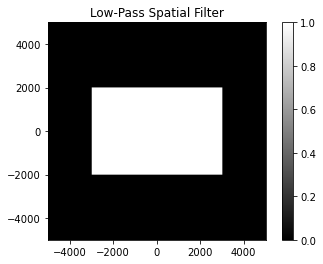

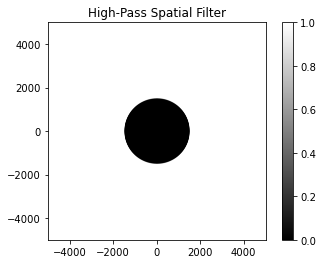

In [7]:
#Defining spatial filters for first Fourier transform

#Low-pass filter
lowpass_aperture = np.ones([nPoints,nPoints])  #2D array filled with zeros
N = range(nPoints)         #1D array from 0 to nPoints-1
xi, yi = np.meshgrid(N,N)  #2D array for x and y indices

lowpass_mask = (abs(xvals[xi]) < 30000) & (abs(yvals[yi]) < 22000)
lowpass_mask = lowpass_mask & (abs(xvals[xi]) > 3000) | (abs(yvals[yi]) > 2000)
lowpass_aperture[lowpass_mask] = 0

plt.imshow(lowpass_aperture, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-5000,5000])
plt.gca().set_ylim([-5000,5000])
plt.title('Low-Pass Spatial Filter')
plt.colorbar()
plt.show()

#High-pass filter
highpass_aperture = np.ones([nPoints,nPoints])  #2D array filled with zeros
N = range(nPoints)         #1D array from 0 to nPoints-1
xi, yi = np.meshgrid(N,N)  #2D array for x and y indices

highpass_mask = (abs(yvals[yi]**2 + abs(xvals[xi])**2 < 1500**2))
highpass_aperture[highpass_mask] = 0

plt.imshow(highpass_aperture, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-5000,5000])
plt.gca().set_ylim([-5000,5000])
plt.title('High-Pass Spatial Filter')
plt.colorbar()
plt.show()


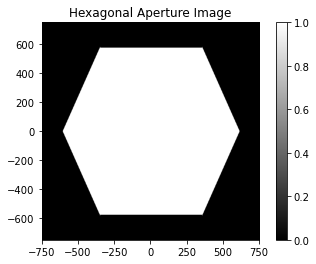

In [22]:
#Defining hexagonal aperture

hex_aperture = np.zeros([nPoints,nPoints])  #2D array filled with zeros
N = range(nPoints)         #1D array from 0 to nPoints-1
xi, yi = np.meshgrid(N,N)  #2D array for x and y indices


#Using a mask to return True whenever condition is satisfied and False otherwise
hex_mask = (abs(yvals[yi]) < 575) & (abs(xvals[xi]) < 350)  #rectangle for base of hexagon
hex_mask = hex_mask | (abs(yvals[yi]) + 2.25*abs(xvals[xi]) < 1370) & (abs(xvals[xi]) > 350)  #triangles to complete hexagon


#Setting aperture to 1 whenever hex_mask is True
hex_aperture[hex_mask] = 1


#Plotting image of the hexagonal aperture
plt.imshow(hex_aperture, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.title('Hexagonal Aperture Image')
plt.colorbar()
plt.show()


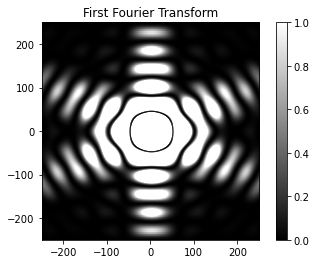

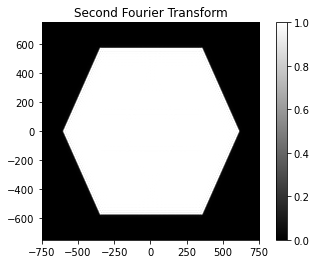

In [40]:
#Computing Fourier transforms of optical system for hexagonal aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(hex_aperture)


#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
hex_screen1 = np.abs(eField)**2     #irradiance at the screen

plt.imshow(hex_screen1, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-250,250])
plt.gca().set_ylim([-250,250])
plt.colorbar()
plt.clim(0,1)
plt.title('First Fourier Transform')
plt.show()


#Computing Fourier Transform after second lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
hex_screen2 = np.abs(eField**2)     #irradiance at the screen

plt.imshow(hex_screen2, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,1)
plt.title('Second Fourier Transform')
plt.show()


In [41]:
#Importing measured hexagonal-array data

#Second Fourier transform - normalizing irrradiance and position
hexsecondft = read_csv('hexagonsecondft.csv', 475)
hexsecondft_range = []
hexsecondft_norm = []
for i in range(1600):
    hexsecondft_range.append(-3375+(4.4*i))
    hexsecondft_norm.append((hexsecondft[i]/1250)-0.05)
    
    
#Low-pass filter after first Fourier transform - normalizing irradiance and position
hexlowpass = read_csv('hexagonlowpass.csv', 523)
hexlowpass_range = []
hexlowpass_norm = []
for i in range(1600):
    hexlowpass_range.append(-4210+(4.4*i))
    hexlowpass_norm.append((hexlowpass[i]/2500)-0.02)
    
    
#High-pass filter after first Fourier transform - normalizing irradiance and position
hexhighpass = read_csv('hexagonhighpass.csv', 640)
hexhighpass_range = []
hexhighpass_norm = []
for i in range(1600):
    hexhighpass_range.append(-4100+(4.4*i))
    hexhighpass_norm.append((hexhighpass[i]/20000)-0.0025)
    

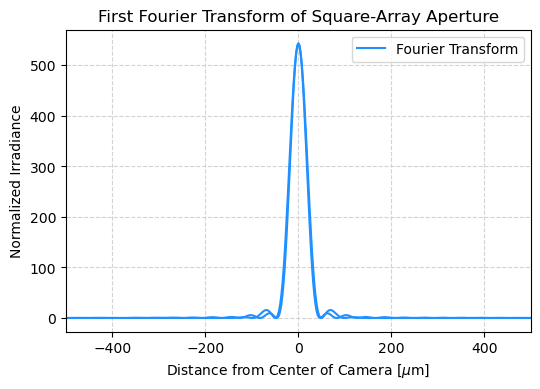

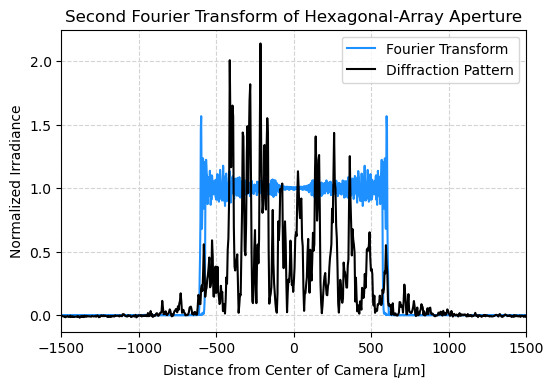

In [42]:
#Irradiance plots vs measured data for square-array aperture

#Line plot of irradiance after first lens
lineplotx = hex_screen1[nPoints//2, :]
lineploty = hex_screen1[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='dodgerblue')
plt.plot(yvals, lineploty, linestyle='solid', color='dodgerblue', label='Fourier Transform')
#plt.plot(squarefirstft_range, squarefirstft_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-500,500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('First Fourier Transform of Square-Array Aperture')
plt.legend(prop={'size':10})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


#Line plot of irradiance after second lens
lineplotx = hex_screen2[nPoints//2, :]
lineploty = hex_screen2[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='dodgerblue')
plt.plot(yvals, lineploty, linestyle='solid', color='dodgerblue', label='Fourier Transform')
plt.plot(hexsecondft_range, hexsecondft_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('Second Fourier Transform of Hexagonal-Array Aperture')
plt.legend(prop={'size':10})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


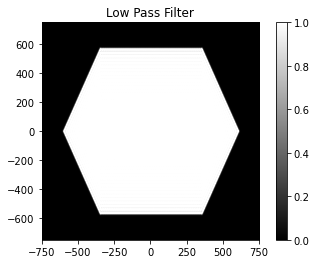

In [43]:
#Computing Fourier transforms of optical system for hexagonal-array aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(hex_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um


#Applying low-pass filter
eField[lowpass_mask] = 0


#Fourier Transform after second lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
hex_screenlow = np.abs(eField**2)   #irradiance at the screen

plt.imshow(hex_screenlow, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,1)
plt.title('Low Pass Filter')
plt.show()


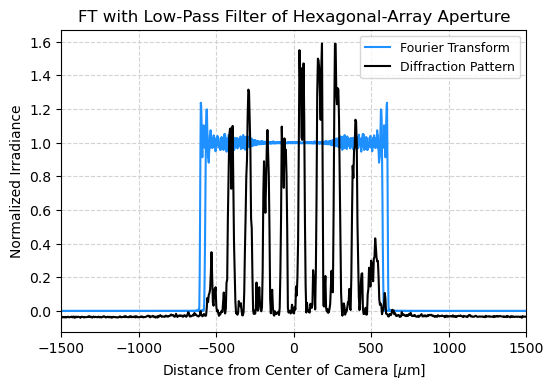

In [44]:
#Line plot of irradiance after low-pass filter
lineplotx = hex_screenlow[nPoints//2, :]
lineploty = hex_screenlow[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='dodgerblue')
plt.plot(yvals, lineploty, linestyle='solid', color='dodgerblue', label='Fourier Transform')
plt.plot(hexlowpass_range, hexlowpass_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('FT with Low-Pass Filter of Hexagonal-Array Aperture')
plt.legend(prop={'size':9})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


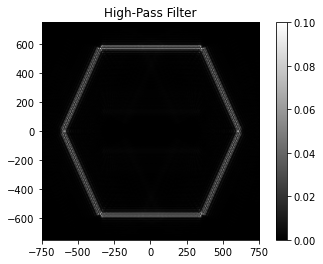

In [46]:
#Computing Fourier transforms of optical system for hexagonal-array aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(hex_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um


#Applying high-pass filter
eField[highpass_mask] = 0


#Fourier Transform after second lens
eField = propEfield(eField, 75000)     #propagate the electric field forward by z0 75mm = 75000um
eField = lensEfield(eField, 75000)     #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)     #propagate the electric field forward by z0 75mm = 75000um
hex_screenhigh = np.abs(eField**2)  #irradiance at the screen

plt.imshow(hex_screenhigh, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,0.1)
plt.title('High-Pass Filter')
plt.show()


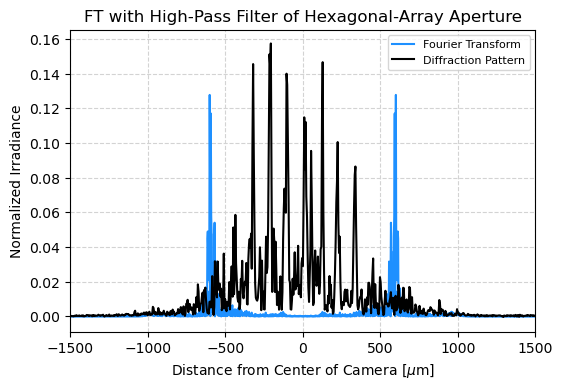

In [47]:
#Line plot of irradiance after high-pass filter
lineplotx = hex_screenhigh[nPoints//2, :]
lineploty = hex_screenhigh[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='dodgerblue')
plt.plot(yvals, lineploty, linestyle='solid', color='dodgerblue', label='Fourier Transform')
plt.plot(hexhighpass_range, hexhighpass_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('FT with High-Pass Filter of Hexagonal-Array Aperture')
plt.legend(prop={'size':8})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


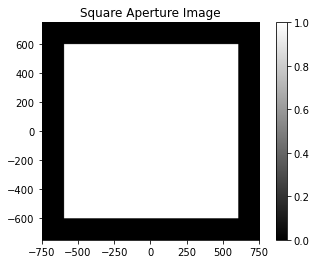

In [48]:
#Defining square aperture

square_aperture = np.zeros([nPoints,nPoints])  #2D array filled with zeros
N = range(nPoints)         #1D array from 0 to nPoints-1
xi, yi = np.meshgrid(N,N)  #2D array for x and y indices


#Using a mask to return True whenever condition is satisfied and False otherwise
square_mask = (abs(yvals[yi]) < 600) & (abs(xvals[xi]) < 600)


#Setting aperture to 1 whenever square_mask is True
square_aperture[square_mask] = 1


#Plotting image of the square aperture
plt.imshow(square_aperture, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.title('Square Aperture Image')
plt.colorbar()
plt.clim(0,1)
plt.show()


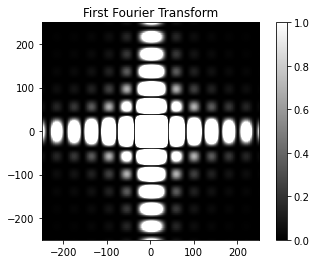

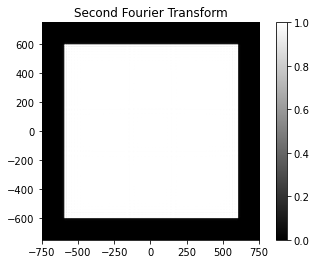

In [50]:
#Computing Fourier transforms of optical system for square aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(square_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)   #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)   #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 150mm = 150000um
square_screen1 = np.abs(eField)**2   #irradiance at the screen

plt.imshow(square_screen1, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-250,250])
plt.gca().set_ylim([-250,250])
plt.colorbar()
plt.clim(0,1)
plt.title('First Fourier Transform')
plt.show()


#Fourier Transform after second lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by z0 (10000 µm in this case)
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 10 mm (in this casE)
eField = propEfield(eField, 75000)  #propagate the electric field forward by z0 (10000 µm in this case)
square_screen2 = np.abs(eField**2)  #irradiance at the screen

plt.imshow(square_screen2, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,1)
plt.title('Second Fourier Transform')
plt.show()


In [51]:
#Importing measured square-array data

#First Fourier transform - normalizing irrradiance and position
squarefirstft = read_csv('squarefirstft.csv', 575)
squarefirstft_range = []
squarefirstft_norm = []
for i in range(1600):
    squarefirstft_range.append(-3280+(4.4*i))
    squarefirstft_norm.append((squarefirstft[i]/4.5)-12)
    

#Second Fourier transform - normalizing irrradiance and position
squaresecondft = read_csv('squaresecondft.csv', 475)
squaresecondft_range = []
squaresecondft_norm = []
for i in range(1600):
    squaresecondft_range.append(-4450+(4.4*i))
    squaresecondft_norm.append((squaresecondft[i]/1000)-0.045)
    
    
#Low-pass filter after first Fourier transform - normalizing irradiance and position
squarelowpass = read_csv('squarelowpass.csv', 235)
squarelowpass_range = []
squarelowpass_norm = []
for i in range(1600):
    squarelowpass_range.append(-4075+(4.4*i))
    squarelowpass_norm.append((squarelowpass[i]/2300)-0.02)
    
    
#High-pass filter after first Fourier transform - normalizing irradiance and position
squarehighpass = read_csv('squarehighpass.csv', 516)
squarehighpass_range = []
squarehighpass_norm = []
for i in range(1600):
    squarehighpass_range.append(-4150+(4.4*i))
    squarehighpass_norm.append((squarehighpass[i]/40000)-0.001)


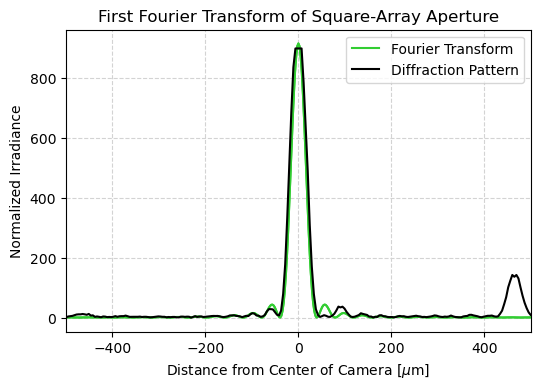

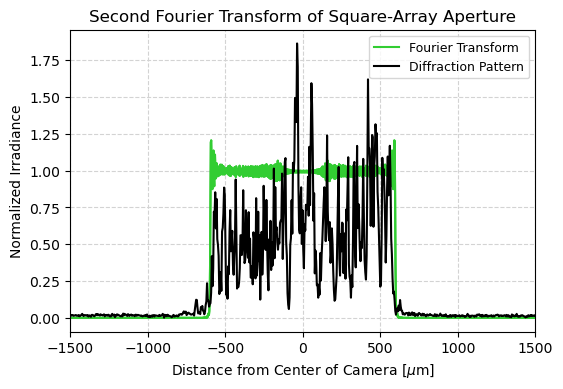

In [52]:
#Irradiance plots vs measured data for square-array aperture

#Line plot of irradiance after first lens
lineplotx = square_screen1[nPoints//2, :]
lineploty = square_screen1[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='limegreen')
plt.plot(yvals, lineploty, linestyle='solid', color='limegreen', label='Fourier Transform')
plt.plot(squarefirstft_range, squarefirstft_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-500,500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('First Fourier Transform of Square-Array Aperture')
plt.legend(prop={'size':10})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


#Line plot of irradiance after second lens
lineplotx = square_screen2[nPoints//2, :]
lineploty = square_screen2[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='limegreen')
plt.plot(yvals, lineploty, linestyle='solid', color='limegreen', label='Fourier Transform')
plt.plot(squaresecondft_range, squaresecondft_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('Second Fourier Transform of Square-Array Aperture')
plt.legend(prop={'size':9})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


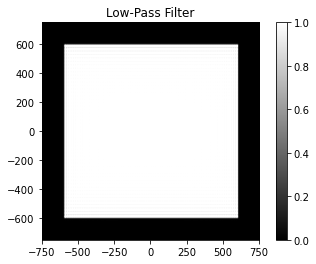

In [55]:
#Computing Fourier transforms of optical system for square-array aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(square_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um


#Applying low-pass filter
eField[lowpass_mask] = 0


#Fourier Transform after second lens
eField = propEfield(eField, 75000)    #propagate the electric field forward by z0 75mm = 75000um
eField = lensEfield(eField, 75000)    #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)    #propagate the electric field forward by z0 75mm = 75000um
square_screenlow = np.abs(eField**2)  #irradiance at the screen

plt.imshow(square_screenlow, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,1)
plt.title('Low-Pass Filter')
plt.show()

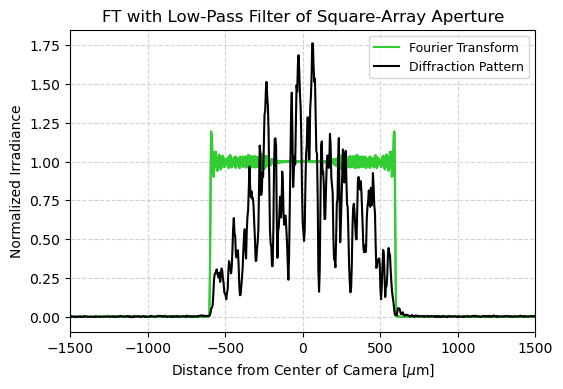

In [56]:
#Line plot of irradiance after low-pass filter
lineplotx = square_screenlow[nPoints//2, :]
lineploty = square_screenlow[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='limegreen')
plt.plot(yvals, lineploty, linestyle='solid', color='limegreen', label='Fourier Transform')
plt.plot(squarelowpass_range, squarelowpass_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('FT with Low-Pass Filter of Square-Array Aperture')
plt.legend(prop={'size':9})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


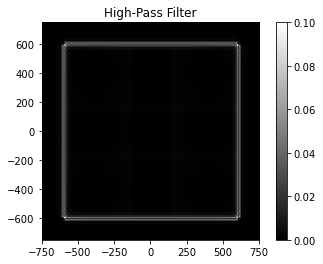

In [57]:
#Computing Fourier transforms of optical system for square-array aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(square_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um


#Applying high-pass filter
eField[highpass_mask] = 0


#Fourier Transform after second lens
eField = propEfield(eField, 75000)     #propagate the electric field forward by z0 75mm = 75000um
eField = lensEfield(eField, 75000)     #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)     #propagate the electric field forward by z0 75mm = 75000um
square_screenhigh = np.abs(eField**2)  #irradiance at the screen

plt.imshow(square_screenhigh, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,0.1)
plt.title('High-Pass Filter')
plt.show()

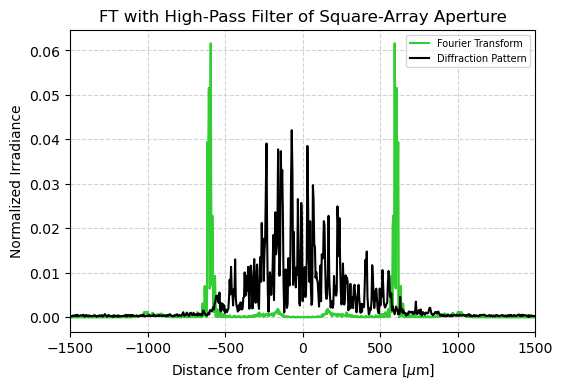

In [58]:
#Line plot of irradiance after high-pass filter
lineplotx = square_screenhigh[nPoints//2, :]
lineploty = square_screenhigh[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='limegreen')
plt.plot(yvals, lineploty, linestyle='solid', color='limegreen', label='Fourier Transform')
plt.plot(squarehighpass_range, squarehighpass_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('FT with High-Pass Filter of Square-Array Aperture')
plt.legend(prop={'size':7})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


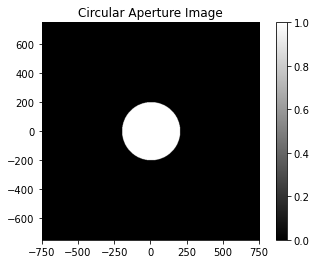

In [67]:
#Defining circular aperture

circ_aperture = np.zeros([nPoints,nPoints])  #2D array filled with zeros
N = range(nPoints)         #1D array from 0 to nPoints-1
xi, yi = np.meshgrid(N,N)  #2D array for x and y indices


#Using a mask to return True whenever condition is satisfied and False otherwise
radius = 200  #radius of circular aperture [um]
circ_mask = (yvals[yi]**2 + xvals[xi]**2 < radius**2)


#Setting aperture to 1 whenever square_mask is True
circ_aperture[circ_mask] = 1


#Plotting image of the square aperture
plt.imshow(circ_aperture, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.title('Circular Aperture Image')
plt.colorbar()
plt.show()


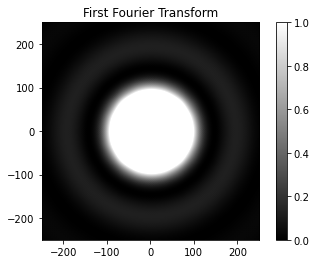

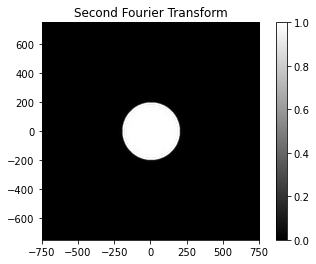

In [68]:
#Computing Fourier transforms of optical system for circular aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(circ_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
circ_screen1 = np.abs(eField)**2    #irradiance at the screen

plt.imshow(circ_screen1, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-250,250])
plt.gca().set_ylim([-250,250])
plt.colorbar()
plt.clim(0,1)
plt.title('First Fourier Transform')
plt.show()


#Fourier Transform after second lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by z0 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by z0 75mm = 75000um
circ_screen2 = np.abs(eField**2)    #irradiance at the screen

plt.imshow(circ_screen2, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,1)
plt.title('Second Fourier Transform')
plt.show()


In [89]:
#Importing measured circular data

#First Fourier transform - normalizing irrradiance and position
circlefirstft = read_csv('circlefirstft.csv', 677)
circlefirstft_range = []
circlefirstft_norm = []
for i in range(1600):
    circlefirstft_range.append(-3055+(4.4*i))
    circlefirstft_norm.append(circlefirstft[i]/425)
    

#Second Fourier transform - normalizing irrradiance and position
circlesecondft = read_csv('circlesecondft.csv', 475)
circlesecondft_range = []
circlesecondft_norm = []
for i in range(1600):
    circlesecondft_range.append(-3675+(4.4*i))
    circlesecondft_norm.append(circlesecondft[i]/3450)
    

#Low-pass filter after first Fourier transform - normalizing irradiance and position
circlelowpass = read_csv('circlelowpass.csv', 837)
circlelowpass_range = []
circlelowpass_norm = []
for i in range(1600):
    circlelowpass_range.append(-2965+(4.4*i))
    circlelowpass_norm.append(circlelowpass[i]/2750)
    
    
#High-pass filter after first Fourier transform - normalizing irradiance and position
circlehighpass = read_csv('circlehighpass.csv', 534)
circlehighpass_range = []
circlehighpass_norm = []
for i in range(1600):
    circlehighpass_range.append(-2990+(4.4*i))
    circlehighpass_norm.append(circlehighpass[i]/60000)
    

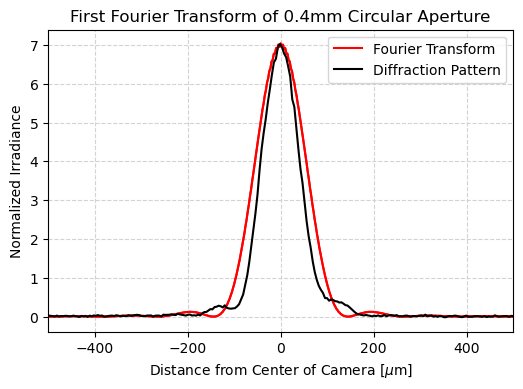

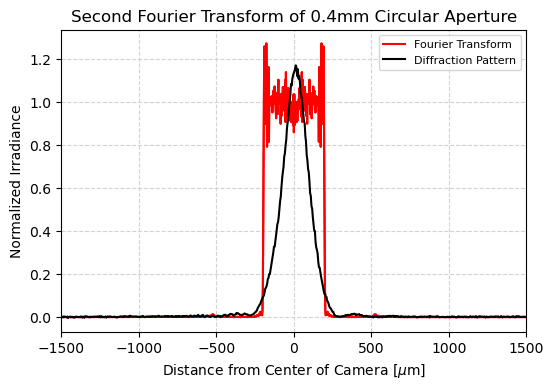

In [80]:
#Irradiance plots vs measured data for circular aperture

#Line plot of irradiance after first lens
lineplotx = circ_screen1[nPoints//2, :]
lineploty = circ_screen1[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='red')
plt.plot(yvals, lineploty, linestyle='solid', color='red', label='Fourier Transform')
plt.plot(circlefirstft_range, circlefirstft_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-500,500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('First Fourier Transform of 0.4mm Circular Aperture')
plt.legend(prop={'size':10})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


#Line plot of irradiance after second lens
lineplotx = circ_screen2[nPoints//2, :]
lineploty = circ_screen2[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='red')
plt.plot(yvals, lineploty, linestyle='solid', color='red', label='Fourier Transform')
plt.plot(circlesecondft_range, circlesecondft_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('Second Fourier Transform of 0.4mm Circular Aperture')
plt.legend(prop={'size':8})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


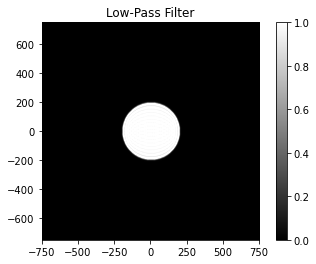

In [81]:
#Computing Fourier transforms of optical system for circular aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(circ_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um


#Applying low-pass filter
eField[lowpass_mask] = 0


#Fourier Transform after second lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by z0 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by z0 75mm = 75000um
circ_screenlow = np.abs(eField**2)  #irradiance at the screen

plt.imshow(circ_screenlow, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,1)
plt.title('Low-Pass Filter')
plt.show()


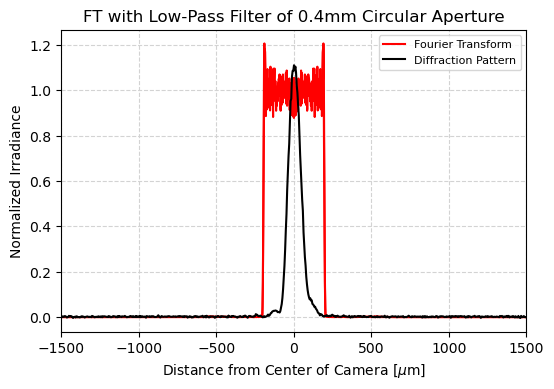

In [86]:
#Line plot of irradiance after low-pass filter
lineplotx = circ_screenlow[nPoints//2, :]
lineploty = circ_screenlow[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='red')
plt.plot(yvals, lineploty, linestyle='solid', color='red', label='Fourier Transform')
plt.plot(circlelowpass_range, circlelowpass_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('FT with Low-Pass Filter of 0.4mm Circular Aperture')
plt.legend(prop={'size':8})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()


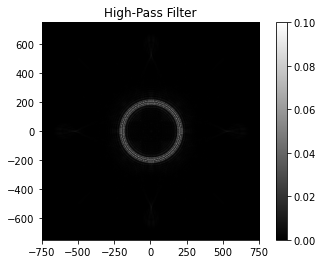

In [87]:
#Computing Fourier transforms of optical system for circular aperture

#Taking square root of irradiance gives electric field "image" to pass to function
eField = sqrt(circ_aperture)

#Fourier transform after first lens
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um
eField = lensEfield(eField, 75000)  #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)  #propagate the electric field forward by 75mm = 75000um


#Applying high-pass filter
eField[highpass_mask] = 0


#Fourier Transform after second lens
eField = propEfield(eField, 75000)   #propagate the electric field forward by z0 75mm = 75000um
eField = lensEfield(eField, 75000)   #applies a lens to e-field with a focal distance of 75mm
eField = propEfield(eField, 75000)   #propagate the electric field forward by z0 75mm = 75000um
circ_screenhigh = np.abs(eField**2)  #irradiance at the screen

plt.imshow(circ_screenhigh, extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length], cmap='gist_gray')
plt.gca().set_xlim([-750,750])
plt.gca().set_ylim([-750,750])
plt.colorbar()
plt.clim(0,0.1)
plt.title('High-Pass Filter')
plt.show()


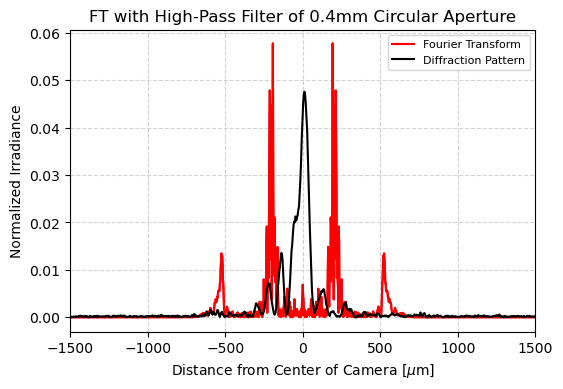

In [90]:
#Line plot of irradiance after high-pass filter
lineplotx = circ_screenhigh[nPoints//2, :]
lineploty = circ_screenhigh[:, nPoints//2]
plt.figure(figsize=(6,4),dpi=100)
plt.plot(xvals, lineplotx, linestyle='solid', color='red')
plt.plot(yvals, lineploty, linestyle='solid', color='red', label='Fourier Transform')
plt.plot(circlehighpass_range, circlehighpass_norm, linestyle='solid', color='black', label='Diffraction Pattern')
plt.grid(True, linestyle='dashed', color='lightgray')
plt.gca().set_xlim([-1500,1500])
plt.xlabel('Distance from Center of Camera [$\mu$m]')
plt.ylabel('Normalized Irradiance')
plt.title('FT with High-Pass Filter of 0.4mm Circular Aperture')
plt.legend(prop={'size':8})
plt.rcParams['legend.loc'] = 'upper right'
plt.show()
